# Trabajo Práctico 2 : Críticas cinematográficas N5

# Grupo: GPWin - N° 16

Integrantes:

- DIEM, Walter Gabriel

- MAIOLO, Alejandro

## Resumen

En esta notebook se exploran los siguientes modelos:

- Un modelo perceptrón multicapa con input de un vectorizer (count vectorizer + tfidf transformer) de unigramas
- Un modelo perceptrón multicapa con input de un vectorizer (count vectorizer + tfidf transformer) de bigramas
- Un modelo perceptrón multicapa con input de un vectorizer (count vectorizer + tfidf transformer) de unigramas y bigramas
- Un modelo perceptrón multicapa con dropout y regularización L2 con input de un vectorizer (count vectorizer + tfidf transformer) de unigramas y bigramas
- Un modelo red neuronal de deep learning con input de un vectorizer (count vectorizer + tfidf transformer) de unigramas y bigramas

## Preprocesamiento

Preparación de librerías

In [1]:
#%pip install joblib visualkeras pydot graphviz keras-visualizer pillow==9.5.0
#%pip install pandas numpy matplotlib optuna seaborn scikit-learn spacy nltk
#%pip install setuptools wheel spacy nltk
#!python -m spacy download es_core_news_sm

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import optuna
import tensorflow as tf

from keras_visualizer import visualizer
import visualkeras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

from tensorflow.python.client import device_lib

from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Para el entrenamiento de las redes neuronales usaremos la versión de tensorflow compilada apta para el uso de GPU

In [3]:
tf.test.is_built_with_cuda()

True

La GPU usada para el entrenamiento es una NVIDIA GeForce RTX 3060 Laptop GPU con memoria dedicada de 6GB de memoria GDDR6

In [4]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-12-07 20:57:06.208454: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 4097 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


True

Seteo final de configuraciones para usar GPU

In [5]:
print(device_lib.list_local_devices())

# Set GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16872988620177042573
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4296605696
locality {
  bus_id: 1
  links {
  }
}
incarnation: 248218292320148584
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2023-12-07 20:57:06.224895: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 4097 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Seteo de semillas para mejor reproducción de resultados

In [6]:
np.random.seed(1)
tf.random.set_seed(1)

### Prepocesamiento de datos

Exploramos el dataset de train y test

In [7]:
critics = pd.read_csv("./datasets/train.csv")
critics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [8]:
criticsTest = pd.read_csv("./datasets/test.csv")
criticsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         8599 non-null   int64 
 1   review_es  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


Tenemos 50k críticas para train y 8.6k entradas para test en Kaggle. Imprimimos una muestra para ver cómo son.

In [9]:
for critic in critics.sample(20)["review_es"]:
    print("###---###")
    print(critic)

###---###
Sin héroes muertos, se obtienen líneas estúpidas como esa, ya que se debe ver esta película de acción lamentablemente abismal. William Sanders es salvada por su amigo Harry Cotter durante una extracción en Vietnam, pero el enemigo capturado por el enemigo. Avance rápido de diez años y Harry ahora es un operario ruso en lavado de cerebro con un microchip de control mental implantado en su cerebro. Su nuevo Superior Ruso es Ivan jugó a la empuñadura obscena por Nick Nicholson, quien podría agregar no solo no intenta hablar con un acento ruso, sino que se parece a más un asistente de gasolina en Kentucky con sus dientes manchados. Lo que es aún más absurdo es el hecho de que también fue el entrenador de diálogo para esta película. Pronto William es re-reclutado por la CIA para cazar a Harry. Se adapta a Barbara, un luchador por la libertad que ha infiltrado el campamento de El Salvador de Ivan y pronto los dos están soplando la mitad de América del Sur. Algunas escenas son tan h

Cambiamos el nombre de la columna `review_es` a sólo `review`

In [10]:
critics.rename(columns={"review_es": "review"}, inplace=True)
critics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review       50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


Revisamos valores nulos

In [11]:
criticsNull = critics.isnull().any()
criticsNull

ID             False
review         False
sentimiento    False
dtype: bool

No hay valores nulos en el dataset. Revisamos el balance entre reviews negativas y positivas 

In [12]:
critics["sentimiento"].value_counts()

positivo    25000
negativo    25000
Name: sentimiento, dtype: int64

Hay la misma cantidad de reviews positivas y negativas

Hacemos una función que a cada review le pasará a minúscula las palabras que no estén completamente escritas es mayúsculas

In [13]:
def toLowercaseIfNotFullyUppercase(review):
    words = review.split()
    parsedReview = []

    for word in words:
        if word.isupper():
            parsedReview.append(word)
        else:
            parsedReview.append(word.lower())

    return ' '.join(parsedReview)

In [14]:
critics["review"].apply(toLowercaseIfNotFullyUppercase)

0        uno de los otros críticos ha mencionado que de...
1        una pequeña pequeña producción.la técnica de f...
2        pensé que esta era una manera maravillosa de p...
3        básicamente, hay una familia donde un niño peq...
4        el "amor en el tiempo" de petter mattei es una...
                               ...                        
49995    pensé que esta película hizo un buen trabajo a...
49996    mala parcela, mal diálogo, mala actuación, dir...
49997    soy católica enseñada en escuelas primarias pa...
49998    voy a tener que estar en desacuerdo con el com...
49999    nadie espera que las películas de star trek se...
Name: review, Length: 50000, dtype: object

Encodeamos con LabelEncoder a los sentimientos

In [15]:
labelEncoder = LabelEncoder()
labelEncoder.fit(critics["sentimiento"])

print("Encoding queda:")
print(f"0 = {labelEncoder.inverse_transform([0])[0]}\n1 = {labelEncoder.inverse_transform([1])[0]}")

Encoding queda:
0 = negativo
1 = positivo


In [16]:
critics["sentimiento"] = labelEncoder.transform(critics["sentimiento"])
critics["sentimiento"].sample(4)

45997    0
9976     1
48042    0
3714     0
Name: sentimiento, dtype: int64

Creamos una función que remueva caracteres que no sean una palabra con espacios y los cambiamos por un espacio

In [17]:
def removePunctuation(review):
    return re.sub(r'[^\w\s]', ' ', review)

In [18]:
critics["review"] = critics["review"].apply(removePunctuation)
critics["review"].sample(10)

20895    El único bien  ya sea de los problemas  las pe...
35913    Si bien esto está horriblemente anticuado  deb...
29522    Mark Frechette Estrella como Mark  una univers...
8761     Si es cierto que el sadomasoquismo es una mone...
49943     SIR  ha jugado a LEAR más de 200 veces  pero ...
851      Steven Seagal s films of late have not exactly...
31578     Paso  Hanna Barbera de los años 60 y 70   Qué...
33833    Desde los primeros 10 segundos de tono de negr...
22722    Esta es la peor película absoluta que he visto...
23456    Después de haber visto al cazador de ciervos  ...
Name: review, dtype: object

In [19]:
def removeDigits(review):
    return re.sub('\d+', '', review)

In [20]:
critics["review"] = critics["review"].apply(removeDigits)
critics["review"].sample(10)

44898    Wow  acabo de presenciarme una de las mayores ...
4099     Esto es sin duda la peor película que he visto...
18059    Esta película no debe clasificarse como cine A...
37702    Como un matriz de béisbol  esta película no co...
47837    Esta fue una película de terror decepcionante ...
43446    Bueno     me gusta esta película en primer lug...
1862     De acuerdo  así que hay una vista frontal de u...
42590    El incidente de Salena es  con mucho  el direc...
3953     Veamos   Cuáles son las ventajas de ver Piranh...
11137    Pink Flamingos is a movie no word can explain ...
Name: review, dtype: object

### Split

Hacemos el split de train y test con relación de ~1/6

In [21]:
critics_x = critics["review"].copy()
critics_y = critics["sentimiento"].copy()

x_train, x_test, y_train, y_test = train_test_split(critics_x,
                                                    critics_y,
                                                    test_size=0.18,
                                                    random_state=0)

### Procesamos conjunto de test de Kaggle

Con el dataset que submitearemos a Kaggle, lo importamos y la hacemos los mismos cambios que se le hicieron al conjunto de training

In [22]:
criticsTest = pd.read_csv("./datasets/test.csv")
criticsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         8599 non-null   int64 
 1   review_es  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


Le cambiamos el nombre a la columna review

In [23]:
criticsTest.rename(columns={"review_es": "review"}, inplace=True)
criticsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      8599 non-null   int64 
 1   review  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


Procesamos las mayúsculas y minúsculas

In [24]:
criticsTest["review"].apply(toLowercaseIfNotFullyUppercase)

0       la mayor virtud de esta película es su existen...
1       no soy un experto cinéfilo, pero pocas veces m...
2       si no eres un incondicional del humor estilo t...
3       no sé qué está pasando, si la gente se deja ll...
4       pero cuando amanece,y me quedo solo,siento en ...
                              ...                        
8594    buena no, lo siguiente. por fin un film serio ...
8595    me esperaba mucho, pero que mucho, más.guión m...
8596    de mal cuerpo como sensación al finalizar, de ...
8597    los que han añadido comentarios os lo han dich...
8598    fui a ver esta película de cine con entusiasmo...
Name: review, Length: 8599, dtype: object

Procesamos los signos de puntación

In [25]:
criticsTest["review"] = criticsTest["review"].apply(removePunctuation)
criticsTest["review"].sample(10)

4571    Si la he visto  fui al cine al estreno cual ad...
4627    Hace cosa de un mes visioné ÁGORA desde el sof...
5802    En este film encontramos retratados diferentes...
6605    Una película bella  aunque de profundos contra...
1850    A estas alturas es un consuelo encontrar una c...
4369    Me gusta Javier Ruiz Caldera  Juega muy bien c...
676     Soy otro de los que no se creen lo que ven en ...
7578    Bueno como el titulo bien dice ayer perdí una ...
10      Pues eso  Una vez más telecinco con su bombard...
1108    Un thriller psicológico muy atrapante  con mom...
Name: review, dtype: object

## Modelo Perceptrón Multicapa usando sólo unigramas

Exploraremos el uso de un modelo de red neuronal perceptrón multicapa. El input será de un vectorizer (count vectorizer más tfidf) fijando los n-gramas solamente en unigramas

Los parámetros del vectorizer los tomamos teniendo en cuenta el mejor set que obtuvimos cuando hicimos la optimización de hiperparámetros del modelo naive bayes

In [26]:
parametersVectorizer = {
    'strip_accents': 'ascii',
    'lowercase': False,
    'ngram_range': (1,1),
    'binary': True,
    'analyzer': 'word'
}

parametersTransformer = {
    'norm': 'l1',
    'use_idf': True,
    'sublinear_tf': True,
}

vectorizer = CountVectorizer(**parametersVectorizer)
tfidfTransformer = TfidfTransformer(**parametersTransformer)

vectorizer.fit(x_train)
tfidfTransformer.fit(vectorizer.transform(x_train))

TfidfTransformer(norm='l1', sublinear_tf=True)

Creamos una función que aplique los pasos de la tokenización

In [27]:
def vectorize(data):
    vectorized = vectorizer.transform(data)
    return tfidfTransformer.transform(vectorized)

Vectorizamos el conjunto de test y train

In [46]:
x_train_vectorized = vectorize(x_train)
x_test_vectorized = vectorize(x_test)

print("Tamaño de la matriz train:", x_train_vectorized.shape)
print("Tamaño de la matriz test:", x_test_vectorized.shape)

Tamaño de la matriz train: (41000, 184799)
Tamaño de la matriz test: (9000, 184799)


Dado que el tamaño de los vectores será 184799, seteamos los tamaños de input y output de la red neuronal

In [47]:
inputVariablesAmount = x_train_vectorized.shape[1]
outputVariablesAmount = 1

print(f"Input layer amount: {inputVariablesAmount}")
print(f"Output layer amount: {outputVariablesAmount}")

Input layer amount: 184799
Output layer amount: 1


La arquitectura de la red constará de una capa de input, una capa densa de 32 neuronas y activación tangente hiperbólica, seguido de otra capa densa de 16 neuronas y activación ReLU, finalizando con una sóla neurona de output y activación sigmoidea para determinar si la review es negativa o positiva.

Durante el entrenamiento observaremos el f1 score y el accuracy. De función de loss tomamos BinaryCrossentropy dado que es un problema de clasificación binaria, y finalmente usaremos el optimizador Nadam.

Esta arquitectura de la red neuronal, y las de las demás redes neuronales también, están inspiradas en la arquitectura presentada en el paper "Aplicación para el análisis de sentimientos y tendencias en redes sociales", escrito por Alejandro Pérez Sanjuán bajo la institución académica de la Universidad Politécnica de Valencia:

https://riunet.upv.es/bitstream/handle/10251/126316/P%C3%A9rez%20-%20Aplicaci%C3%B3n%20para%20el%20an%C3%A1lisis%20de%20sentimientos%20y%20tendencias%20en%20redes%20sociales..pdf?isAllowed=y&sequence=2#cite.pennington2014glove

In [48]:
perceptron = Sequential([
    InputLayer(input_shape=(inputVariablesAmount,)),
    Dense(32, activation="tanh"),
    Dense(16, activation='relu'),
    Dense(outputVariablesAmount, activation='sigmoid')
])

f1Scorer =  tf.keras.metrics.F1Score()
binaryCrossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
adamOptimizer = tf.keras.optimizers.Nadam(learning_rate=0.0001)

perceptron.compile(loss=binaryCrossentropy,
                        optimizer=adamOptimizer,
                        metrics=[f1Scorer, "accuracy"])

perceptron.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                5913600   
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5914145 (22.56 MB)
Trainable params: 5914145 (22.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-12-03 21:14:01.173348: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4097 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


El output del vectorizer es una matriz dispersa, pero lo necesitamos en forma de tensor para entrenar la red, este tensor debe seguir un cierto orden (dado que si no aplicamos un reorder, obtenemos un error). Por eso creamos una función que se aplicará a los datos vectorizados, esta descompone la matriz dispersa en coordenadas con las que luego se compone un tensor disperso. Finalmente se ejecuta un reordenamiento del tensor disperso para que sea apto para el training de la red

In [28]:
def convertSparseMatrixToSparseTensor(X):
    coordinates = X.tocoo()
    indices = np.mat([coordinates.row, coordinates.col]).transpose()
    return tf.SparseTensor(indices, coordinates.data, coordinates.shape)

def reorderSparse(x):
    return tf.sparse.reorder(convertSparseMatrixToSparseTensor(x))

Para evaluar la red neuronal registraremos el validation loss, así que definimos una proporción del conjunto de train que se usará para validación, elegimos un ratio de ~1/6. Entrenaremos a la red por 200 epochs en batches de 512

In [56]:
epochs = 200
batchSize = 512
validationProportion = 0.18

Separamos manualmente las muestras de los conjuntos teniendo en cuenta la proporción de validación, luego le aplicamos la vectorización y el reordenado a los tensores

In [51]:
y_train_float = tf.cast(y_train, tf.float32)

# Manual separation of samples based on validationProportion
validation_samples = int(validationProportion * len(x_train))
x_train_partial = x_train[:-validation_samples]
x_train_partial = vectorize(x_train_partial)
x_train_partial = reorderSparse(x_train_partial)

y_train_partial = y_train_float[:-validation_samples]

x_validation = x_train[-validation_samples:]
x_validation = vectorize(x_validation)
x_validation = reorderSparse(x_validation)

y_validation = y_train_float[-validation_samples:]

Ejecutamos el entrenamiento de la red con la GPU

In [ ]:
with tf.device('/gpu:0'):
    perceptronTrainingHistory = perceptron.fit(x_train_partial,
                                            y_train_partial,
                                            epochs=epochs,
                                            batch_size=batchSize,
                                            validation_data=(x_validation, y_validation),
                                            use_multiprocessing=True,
                                            verbose=0)

Definimos una función para graficar el progreso del f1 score, el accuracy y el loss a través de las epochs

In [58]:
def plotComparisonAlongEpochs(history, epochsParam, infoModel):
    epochsRange = range(epochsParam)
    figure, subplots = plt.subplots(1, 3, figsize=(12, 4))
    plt.ylim(0, 0.8)

    subplots[0].plot(epochsRange, history['f1_score'], color='red', label='f1_score')
    subplots[0].plot(epochsRange, history['val_f1_score'], color='blue', label='f1_score')
    subplots[0].set_xlabel("epochs")
    subplots[0].set_ylabel("f1_score")
    subplots[0].set_ylim(0, 1.0)
    subplots[0].set_xlim(0, epochsParam)
    subplots[0].legend(["train_f1_score", "validation_f1_score"])

    subplots[1].plot(epochsRange, history['accuracy'], color='red', label='loss')
    subplots[1].plot(epochsRange, history['val_accuracy'], color='blue', label='loss')
    subplots[1].set_xlabel("epochs")
    subplots[1].set_ylabel("accuracy")
    subplots[1].set_ylim(0, 1.0)
    subplots[1].set_xlim(0, epochsParam)
    subplots[1].legend(["train_accuracy", "validation_accuracy"])

    subplots[2].plot(epochsRange, history['loss'], color='red', label='loss')
    subplots[2].plot(epochsRange, history['val_loss'], color='blue', label='loss')
    subplots[2].set_xlabel("epochs")
    subplots[2].set_ylabel("loss")
    subplots[2].legend(["train_loss", "validation_loss"])

    maxLoss = max(history['loss'])
    if maxLoss > 1:
        subplots[2].set_ylim(0, maxLoss)
    else:
        subplots[2].set_ylim(0, 1.0)

    subplots[2].set_xlim(0, epochsParam)

    plt.tight_layout()
    figure.suptitle(f"Evolución por época del f1-score y del loss en modelo {infoModel}", y=1.05)
    plt.show()

Mostramos el gráfico comparativo

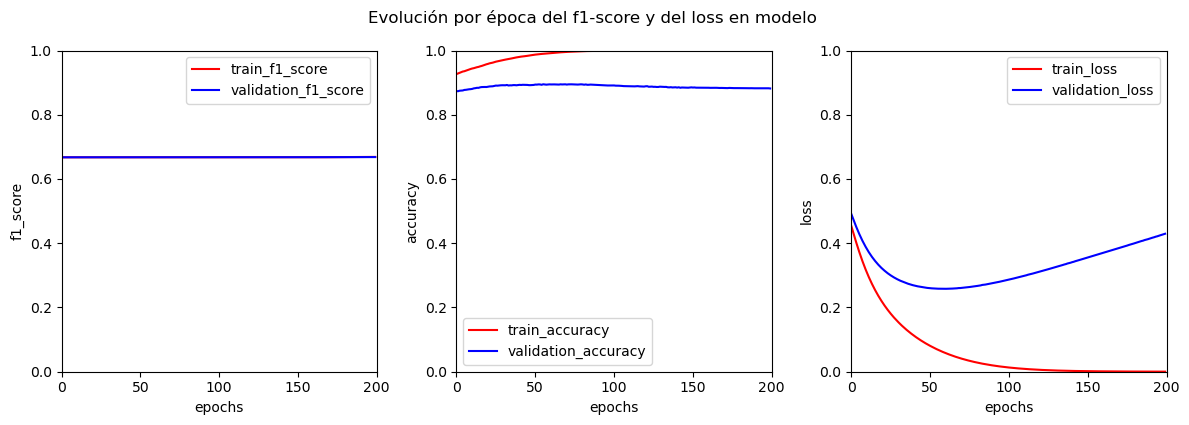

In [59]:
plotComparisonAlongEpochs(perceptronTrainingHistory.history, epochs, "")

En el gráfico se puede observar el punto de inflexión donde la red comienza a hacer overfitting, que es donde el validation loss comienza a ascender

Realizamos una visualización de las capas de la red neuronal y cómo se conectan con la librería keras-visualizer

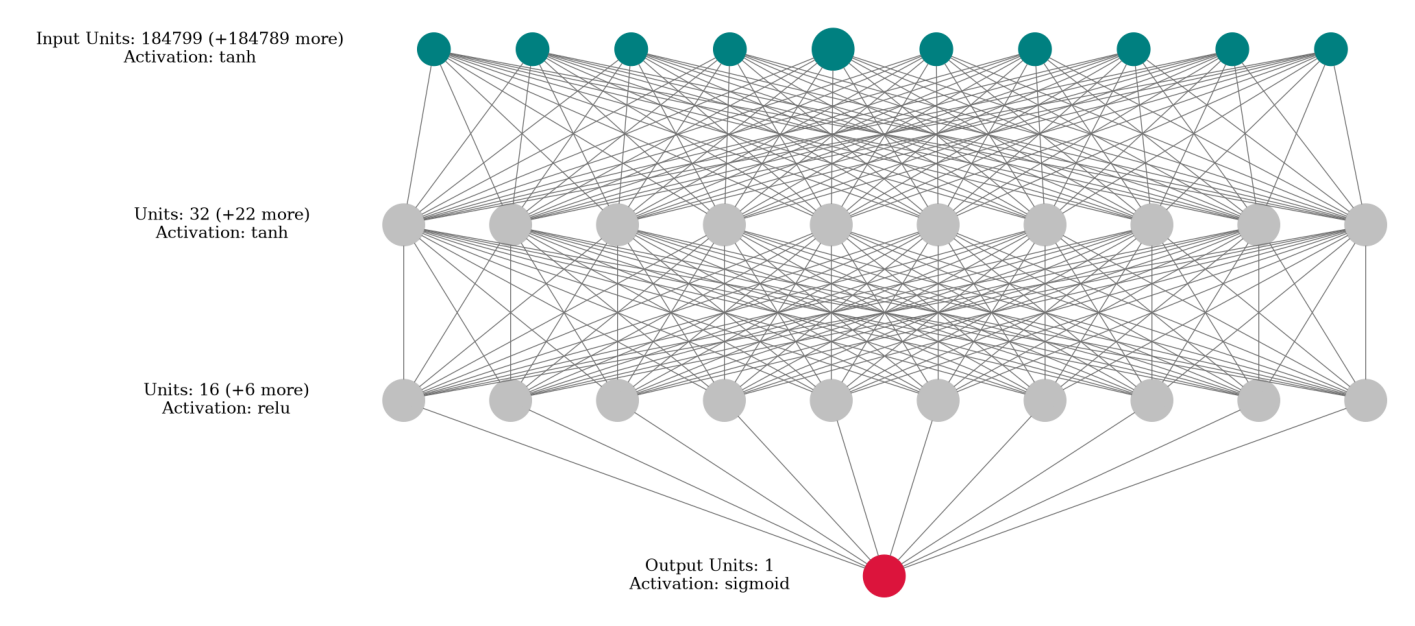

In [5]:
perceptronImagePath = f"./imgs/{runNumber}_perceptron"
my_settings = {
    'INPUT_DENSE_COLOR': 'teal',
    'HIDDEN_DENSE_COLOR': 'gray',
    'OUTPUT_DENSE_COLOR': 'crimson'
}
visualizer(perceptron, view=False, file_name=perceptronImagePath, file_format='png', settings=my_settings)

perceptronImage = plt.imread(f"{perceptronImagePath}.png")

plt.figure(figsize = (18, 16))
plt.axis('off')
plt.imshow(perceptronImage)

Realizamos una visualización de las capas de la red neuronal con la librería visualkeras

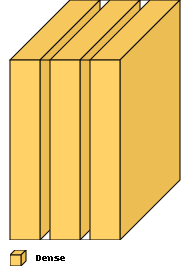

In [6]:
visualkeras.layered_view(perceptron, min_xy=180, min_z=30, legend=True)

Definimos una función para aplicar el procesamiento de datos con una única función antes de mandar a la red, para simplificar la aplicación de las tranformaciones

In [29]:
def processInput(data):
    vectorized = vectorize(data)
    return reorderSparse(vectorized)

Definimos una función para convertir el output de la red, que es una probabilidad, en una decisión binaria (0 para negativo o 1 para positivo)

In [30]:
def convertProbasToClasses(y_pred):
    probaTrigger = 0.5
    return np.where(y_pred > probaTrigger, 1, 0)

Procesamos el conjunto de test y realizamos la predicción

In [32]:
y_pred = perceptron.predict(processInput(x_test))
y_pred = convertProbasToClasses(y_pred)

282/282 [==============================] - 3s 2ms/step


Imprimimos la matriz de confusión. Se agrega una caja de texto con las equivalencias entre las etiquetas numéricas y el sentimiento

F1-Score: 0.8725697144761695


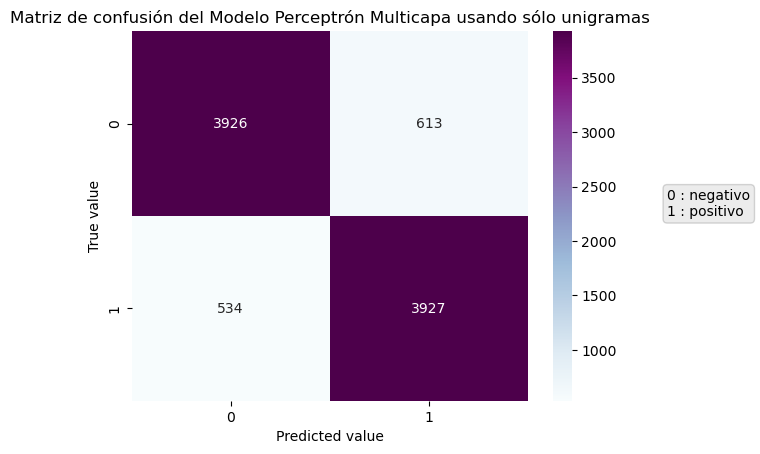

In [33]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

confussionMatrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(confussionMatrix,cmap='BuPu', annot=True, fmt='g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Matriz de confusión del Modelo Perceptrón Multicapa usando sólo unigramas")
plt.text(2.7, 1, f"0 : {labelEncoder.inverse_transform([0])[0]}\n1 : {labelEncoder.inverse_transform([1])[0]}", bbox=dict(boxstyle='round', facecolor='grey', alpha=0.15))
plt.show()

Mostramos las distintas métricas

In [66]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.8725555555555555
Recall: 0.8802958977807667
Precision: 0.864977973568282
f1 score: 0.8725697144761695


Realizamos las predicciones de los datos que vamos a submitear a kaggle

In [69]:
y_pred = perceptron.predict(processInput(criticsTest["review"]))
y_pred = convertProbasToClasses(y_pred)

269/269 [==============================] - 0s 1ms/step


Agrupamos en el dataframe los valores predichos decodeados con el label encoder

In [70]:
kaggleResult = criticsTest.copy()
kaggleResult.drop(columns=["review"], inplace=True)

kaggleResult["sentimiento"] = labelEncoder.inverse_transform(y_pred)

kaggleResult.head(2)

,ID,sentimiento
0,60000,negativo
1,60001,negativo


Para exportar a Kaggle exportamos el csv. El `runNumber` es sólo un número que ponemos para no pisar los submits

In [73]:
runNumber = 20

In [74]:
kaggleResult.to_csv(f"submit_{runNumber}_grupo16_gpwin_perceptron_multicapa.csv", index=False)

Guardamos una serialización del modelo

In [75]:
filename = f'./perceptron_multicapa_model_{runNumber}.joblib'
modelInfo = {'model': perceptron}

joblib.dump(modelInfo, filename)

['./perceptron_multicapa_model_20.joblib']

## Modelo Perceptrón Multicapa usando sólo bigramas

Exploraremos el uso de un modelo de red neuronal perceptrón multicapa. El input será de un vectorizer (count vectorizer más tfidf) fijando los n-gramas solamente en bigramas

Los parámetros del vectorizer los tomamos teniendo en cuenta el mejor set que obtuvimos cuando hicimos la optimización de hiperparámetros del modelo naive bayes

In [26]:
parametersVectorizer = {
    'strip_accents': 'ascii',
    'lowercase': False,
    'ngram_range': (2,2),
    'binary': True,
    'analyzer': 'word'
}

parametersTransformer = {
    'norm': 'l1',
    'use_idf': True,
    'sublinear_tf': True,
}

vectorizer = CountVectorizer(**parametersVectorizer)
tfidfTransformer = TfidfTransformer(**parametersTransformer)

vectorizer.fit(x_train)
tfidfTransformer.fit(vectorizer.transform(x_train))

TfidfTransformer(norm='l1', sublinear_tf=True)

Creamos una función que aplique los pasos de la tokenización

In [27]:
def vectorize(data):
    vectorized = vectorizer.transform(data)
    return tfidfTransformer.transform(vectorized)

Vectorizamos el conjunto de test y train

In [46]:
x_train_vectorized = vectorizer.transform(x_train)
x_train_vectorized = tfidfTransformer.transform(x_train_vectorized)

x_test_vectorized = vectorizer.transform(x_test)
x_test_vectorized = tfidfTransformer.transform(x_test_vectorized)
print("Tamaño de la matriz train:", x_train_vectorized.shape)
print("Tamaño de la matriz test:", x_test_vectorized.shape)

Tamaño de la matriz train: (41000, 2373052)
Tamaño de la matriz test: (9000, 2373052)


Dado que el tamaño de los vectores será 2373052, seteamos los tamaños de input y output de la red neuronal

In [47]:
inputVariablesAmount = x_train_vectorized.shape[1]
outputVariablesAmount = 1

print(f"Input layer amount: {inputVariablesAmount}")
print(f"Output layer amount: {outputVariablesAmount}")

Input layer amount: 2373052
Output layer amount: 1


La arquitectura de la red constará de una capa de input, una capa densa de 32 neuronas y activación tangente hiperbólica, seguido de otra capa densa de 16 neuronas y activación ReLU, finalizando con una sóla neurona de output y activación sigmoidea para determinar si la review es negativa o positiva.

Durante el entrenamiento observaremos el f1 score y el accuracy. De función de loss tomamos BinaryCrossentropy dado que es un problema de clasificación binaria, y finalmente usaremos el optimizador Nadam.

In [48]:
perceptron = Sequential([
    InputLayer(input_shape=(inputVariablesAmount,)),
    Dense(32, activation="tanh"),
    Dense(16, activation='relu'),
    Dense(outputVariablesAmount, activation='sigmoid')
])

f1Scorer =  tf.keras.metrics.F1Score()
binaryCrossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
adamOptimizer = tf.keras.optimizers.Nadam(learning_rate=0.0001)

perceptron.compile(loss=binaryCrossentropy,
                        optimizer=adamOptimizer,
                        metrics=[f1Scorer, "accuracy"])

perceptron.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                75937696  
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 75938241 (289.68 MB)
Trainable params: 75938241 (289.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-12-04 09:26:12.762218: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4097 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


El output del vectorizer es una matriz dispersa, pero lo necesitamos en forma de tensor para entrenar la red, este tensor debe seguir un cierto orden (dado que si no aplicamos un reorder, obtenemos un error). Por eso creamos una función que se aplicará a los datos vectorizados, esta descompone la matriz dispersa en coordenadas con las que luego se compone un tensor disperso. Finalmente se ejecuta un reordenamiento del tensor disperso para que sea apto para el training de la red

In [28]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

def reorderSparse(x):
    return tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(x))

Para evaluar la red neuronal registraremos el validation loss, así que definimos una proporción del conjunto de train que se usará para validación, elegimos un ratio de ~1/6. Entrenaremos a la red por 100 epochs en batches de 512

In [50]:
epochs = 100
batchSize = 512
validationProportion = 0.18

Separamos manualmente las muestras de los conjuntos teniendo en cuenta la proporción de validación, luego le aplicamos la vectorización y el reordenado a los tensores

In [51]:
y_train_float = tf.cast(y_train, tf.float32)

# Separar el conjunto de validación manualmente
validation_samples = int(validationProportion * len(x_train))
x_train_partial = x_train[:-validation_samples]
x_train_partial = vectorize(x_train_partial)
x_train_partial = reorderSparse(x_train_partial)

y_train_partial = y_train_float[:-validation_samples]

x_validation = x_train[-validation_samples:]
x_validation = vectorize(x_validation)
x_validation = reorderSparse(x_validation)

y_validation = y_train_float[-validation_samples:]

Ejecutamos el entrenamiento de la red con la GPU

In [ ]:
with tf.device('/gpu:0'):
    perceptronTrainingHistory = perceptron.fit(x_train_partial,
                                            y_train_partial,
                                            epochs=epochs,
                                            batch_size=batchSize,
                                            validation_data=(x_validation, y_validation),
                                            use_multiprocessing=True,
                                            verbose=0)

Entrenamos por 20 epochs más

In [ ]:
with tf.device('/gpu:0'):
    perceptronTrainingHistory = perceptron.fit(x_train_partial,
                                            y_train_partial,
                                            epochs=20,
                                            batch_size=batchSize,
                                            validation_data=(x_validation, y_validation),
                                            use_multiprocessing=True,
                                            verbose=0)

Entrenamos otros 20 epochs más

In [ ]:
with tf.device('/gpu:0'):
    perceptronTrainingHistory = perceptron.fit(x_train_partial,
                                            y_train_partial,
                                            epochs=20,
                                            batch_size=batchSize,
                                            validation_data=(x_validation, y_validation),
                                            use_multiprocessing=True,
                                            verbose=0)

Definimos una función para graficar el progreso del f1 score, el accuracy y el loss a través de las epochs

In [53]:
def plotComparisonAlongEpochs(history, epochsParam, infoModel):
    epochsRange = range(epochsParam)
    figure, subplots = plt.subplots(1, 3, figsize=(12, 4))
    plt.ylim(0, 0.8)

    subplots[0].plot(epochsRange, history['f1_score'], color='red', label='f1_score')
    subplots[0].plot(epochsRange, history['val_f1_score'], color='blue', label='f1_score')
    subplots[0].set_xlabel("epochs")
    subplots[0].set_ylabel("f1_score")
    subplots[0].set_ylim(0, 1.0)
    subplots[0].set_xlim(0, epochsParam)
    subplots[0].legend(["train_f1_score", "validation_f1_score"])

    subplots[1].plot(epochsRange, history['accuracy'], color='red', label='loss')
    subplots[1].plot(epochsRange, history['val_accuracy'], color='blue', label='loss')
    subplots[1].set_xlabel("epochs")
    subplots[1].set_ylabel("accuracy")
    subplots[1].set_ylim(0, 1.0)
    subplots[1].set_xlim(0, epochsParam)
    subplots[1].legend(["train_accuracy", "validation_accuracy"])

    subplots[2].plot(epochsRange, history['loss'], color='red', label='loss')
    subplots[2].plot(epochsRange, history['val_loss'], color='blue', label='loss')
    subplots[2].set_xlabel("epochs")
    subplots[2].set_ylabel("loss")
    subplots[2].legend(["train_loss", "validation_loss"])

    maxLoss = max(history['loss'])
    if maxLoss > 1:
        subplots[2].set_ylim(0, maxLoss)
    else:
        subplots[2].set_ylim(0, 1.0)

    subplots[2].set_xlim(0, epochsParam)

    plt.tight_layout()
    figure.suptitle(f"Evolución por época del f1-score y del loss en modelo {infoModel}", y=1.05)
    plt.show()

Mostramos el gráfico comparativo, teniendo en cuenta las primeras 100 epochs

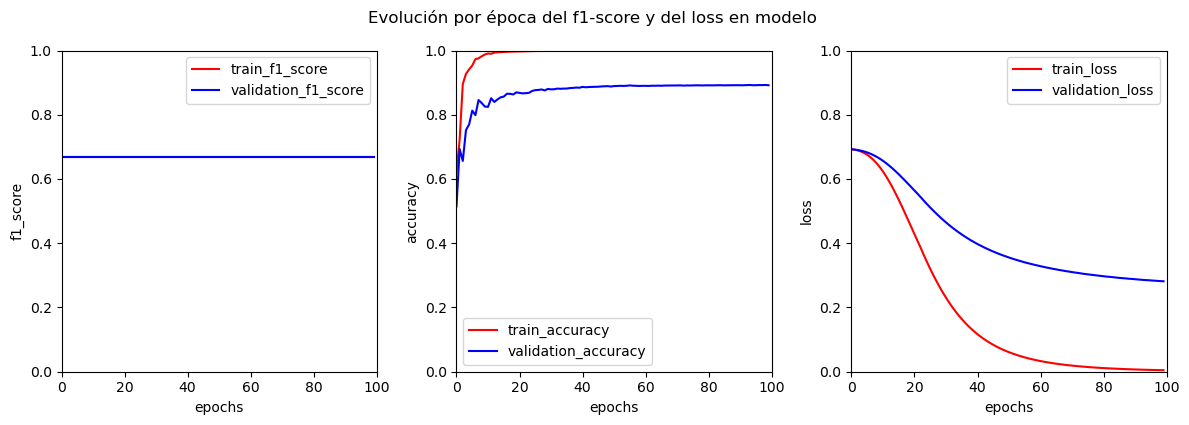

In [54]:
plotComparisonAlongEpochs(perceptronTrainingHistory.history, epochs, "")

En este caso, hasta estas epochs, el modelo no llegó a hacer overfitting

Realizamos una visualización de las capas de la red neuronal y cómo se conectan con la librería keras-visualizer

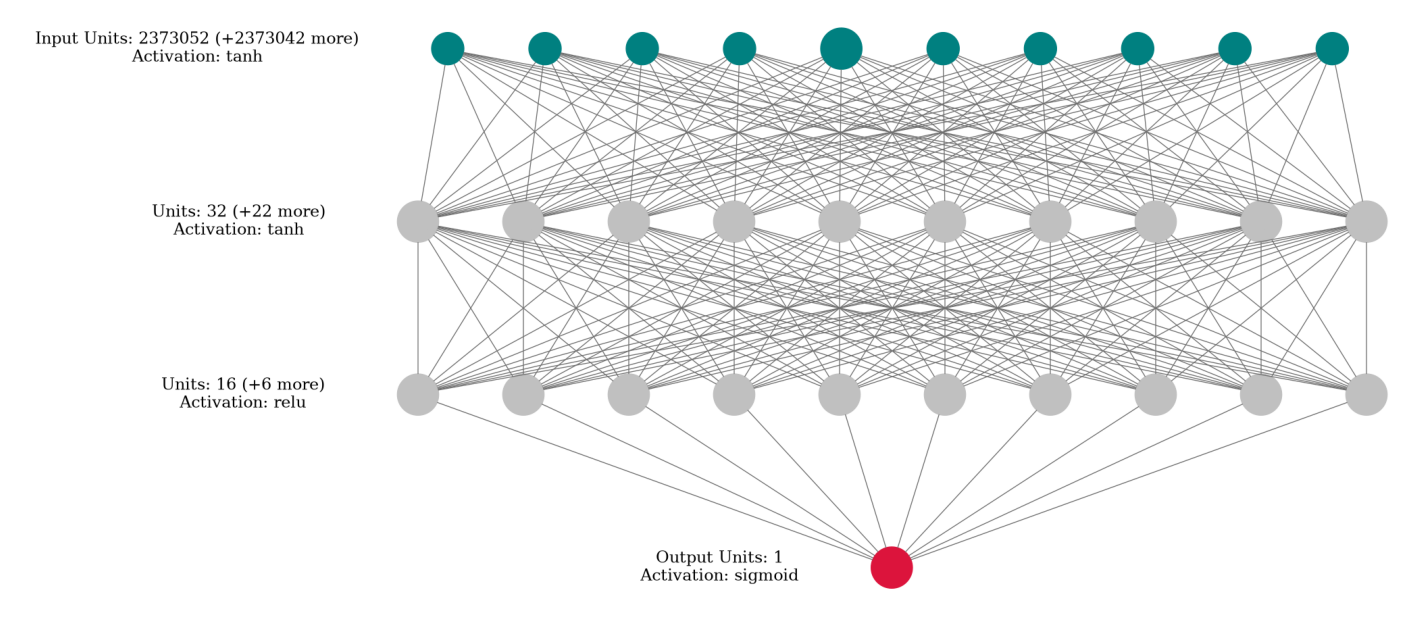

In [8]:
perceptronImagePath = f"./imgs/{runNumber}_perceptron"
my_settings = {
    'INPUT_DENSE_COLOR': 'teal',
    'HIDDEN_DENSE_COLOR': 'gray',
    'OUTPUT_DENSE_COLOR': 'crimson'
}
visualizer(perceptron, view=False, file_name=perceptronImagePath, file_format='png', settings=my_settings)

perceptronImage = plt.imread(f"{perceptronImagePath}.png")

plt.figure(figsize = (18, 16))
plt.axis('off')
plt.imshow(perceptronImage)

Realizamos una visualización de las capas de la red neuronal con la librería visualkeras

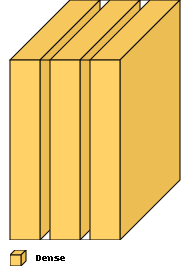

In [9]:
visualkeras.layered_view(perceptron, min_xy=180, min_z=30, legend=True)

Definimos una función para aplicar el procesamiento de datos con una única función antes de mandar a la red, para simplificar la aplicación de las tranformaciones

In [29]:
def processInput(data):
    vectorized = vectorize(data)
    return reorderSparse(vectorized)

Definimos una función para convertir el output de la red, que es una probabilidad, en una decisión binaria (0 para negativo o 1 para positivo)

In [30]:
def convertProbasToClasses(y_pred):
    probaTrigger = 0.5
    return np.where(y_pred > probaTrigger, 1, 0)

Procesamos el conjunto de test y realizamos la predicción

In [32]:
y_pred = perceptron.predict(processInput(x_test))
y_pred = convertProbasToClasses(y_pred)

282/282 [==============================] - 2s 2ms/step


Imprimimos la matriz de confusión. Se agrega una caja de texto con las equivalencias entre las etiquetas numéricas y el sentimiento

F1-Score: 0.8909753672815642


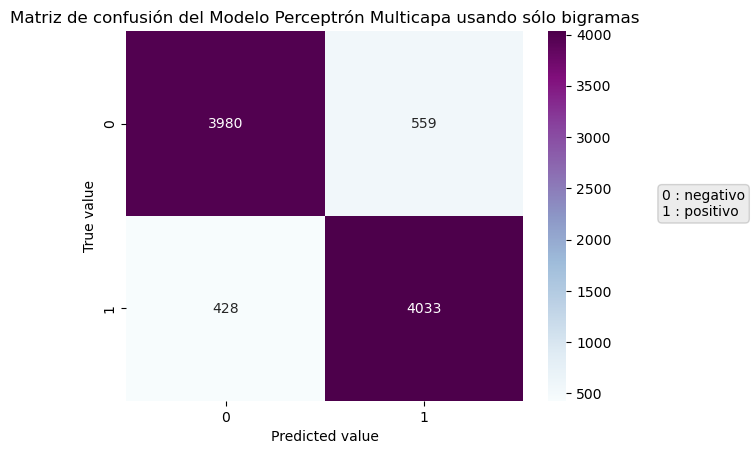

In [33]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

confussionMatrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(confussionMatrix,cmap='BuPu', annot=True, fmt='g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Matriz de confusión del Modelo Perceptrón Multicapa usando sólo bigramas")
plt.text(2.7, 1, f"0 : {labelEncoder.inverse_transform([0])[0]}\n1 : {labelEncoder.inverse_transform([1])[0]}", bbox=dict(boxstyle='round', facecolor='grey', alpha=0.15))
plt.show()

Mostramos las distintas métricas

In [59]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.8903333333333333
Recall: 0.9040573862362699
Precision: 0.8782665505226481
f1 score: 0.8909753672815642


Realizamos las predicciones de los datos que vamos a submitear a kaggle

In [67]:
y_pred = perceptron.predict(processInput(criticsTest["review"]))
y_pred = convertProbasToClasses(y_pred)

269/269 [==============================] - 0s 1ms/step


Agrupamos en el dataframe los valores predichos decodeados con el label encoder

In [68]:
kaggleResult = criticsTest.copy()
kaggleResult.drop(columns=["review"], inplace=True)

kaggleResult["sentimiento"] = labelEncoder.inverse_transform(y_pred)

kaggleResult.head(2)

,ID,sentimiento
0,60000,negativo
1,60001,negativo


Para exportar a Kaggle exportamos el csv. El `runNumber` es sólo un número que ponemos para no pisar los submits

In [69]:
runNumber = 22

In [70]:
kaggleResult.to_csv(f"submit_{runNumber}_grupo16_gpwin_perceptron_multicapa.csv", index=False)

Guardamos una serialización del modelo

In [64]:
filename = f'./perceptron_multicapa_model_{runNumber}.joblib'
modelInfo = {'model': perceptron}

joblib.dump(modelInfo, filename)

['./perceptron_multicapa_model_21.joblib']

## Modelo Perceptrón Multicapa usando unigramas y bigramas

Exploraremos el uso de un modelo de red neuronal perceptrón multicapa. El input será de un vectorizer (count vectorizer más tfidf) fijando los n-gramas en unigramas y bigramas

Los parámetros del vectorizer los tomamos teniendo en cuenta el mejor set que obtuvimos cuando hicimos la optimización de hiperparámetros del modelo naive bayes

In [26]:
parametersVectorizer = {
    'strip_accents': 'ascii',
    'lowercase': False,
    'ngram_range': (1,2),
    'binary': True,
    'analyzer': 'word'
}

parametersTransformer = {
    'norm': 'l1',
    'use_idf': True,
    'sublinear_tf': True,
}

vectorizer = CountVectorizer(**parametersVectorizer)
tfidfTransformer = TfidfTransformer(**parametersTransformer)

vectorizer.fit(x_train)
tfidfTransformer.fit(vectorizer.transform(x_train))

TfidfTransformer(norm='l1', sublinear_tf=True)

Creamos una función que aplique los pasos de la tokenización

In [27]:
def vectorize(data):
    vectorized = vectorizer.transform(data)
    return tfidfTransformer.transform(vectorized)

Vectorizamos el conjunto de test y train

In [46]:
x_train_vectorized = vectorizer.transform(x_train)
x_train_vectorized = tfidfTransformer.transform(x_train_vectorized)

x_test_vectorized = vectorizer.transform(x_test)
x_test_vectorized = tfidfTransformer.transform(x_test_vectorized)
print("Tamaño de la matriz train:", x_train_vectorized.shape)
print("Tamaño de la matriz test:", x_test_vectorized.shape)

Tamaño de la matriz train: (41000, 2557851)
Tamaño de la matriz test: (9000, 2557851)


Dado que el tamaño de los vectores será 2557851, seteamos los tamaños de input y output de la red neuronal

In [47]:
inputVariablesAmount = x_train_vectorized.shape[1]
outputVariablesAmount = 1

print(f"Input layer amount: {inputVariablesAmount}")
print(f"Output layer amount: {outputVariablesAmount}")

Input layer amount: 2557851
Output layer amount: 1


La arquitectura de la red constará de una capa de input, una capa densa de 32 neuronas y activación tangente hiperbólica, seguido de otra capa densa de 16 neuronas y activación ReLU, finalizando con una sóla neurona de output y activación sigmoidea para determinar si la review es negativa o positiva.

Durante el entrenamiento observaremos el f1 score y el accuracy. De función de loss tomamos BinaryCrossentropy dado que es un problema de clasificación binaria, y finalmente usaremos el optimizador Nadam.

In [48]:
perceptron = Sequential([
    InputLayer(input_shape=(inputVariablesAmount,)),
    Dense(32, activation="tanh"),
    Dense(16, activation='relu'),
    Dense(outputVariablesAmount, activation='sigmoid')
])

f1Scorer =  tf.keras.metrics.F1Score()
binaryCrossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
adamOptimizer = tf.keras.optimizers.Nadam(learning_rate=0.0001)

perceptron.compile(loss=binaryCrossentropy,
                        optimizer=adamOptimizer,
                        metrics=[f1Scorer, "accuracy"])

perceptron.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                81851264  
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 81851809 (312.24 MB)
Trainable params: 81851809 (312.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-12-04 09:58:19.546563: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4097 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


El output del vectorizer es una matriz dispersa, pero lo necesitamos en forma de tensor para entrenar la red, este tensor debe seguir un cierto orden (dado que si no aplicamos un reorder, obtenemos un error). Por eso creamos una función que se aplicará a los datos vectorizados, esta descompone la matriz dispersa en coordenadas con las que luego se compone un tensor disperso. Finalmente se ejecuta un reordenamiento del tensor disperso para que sea apto para el training de la red

In [28]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

def reorderSparse(x):
    return tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(x))

Para evaluar la red neuronal registraremos el validation loss, así que definimos una proporción del conjunto de train que se usará para validación, elegimos un ratio de ~1/6. Entrenaremos a la red por 100 epochs en batches de 512

In [50]:
epochs = 100
batchSize = 512
validationProportion = 0.18

Separamos manualmente las muestras de los conjuntos teniendo en cuenta la proporción de validación, luego le aplicamos la vectorización y el reordenado a los tensores

In [51]:
y_train_float = tf.cast(y_train, tf.float32)

# Separar el conjunto de validación manualmente
validation_samples = int(validationProportion * len(x_train))
x_train_partial = x_train[:-validation_samples]
x_train_partial = vectorize(x_train_partial)
x_train_partial = reorderSparse(x_train_partial)

y_train_partial = y_train_float[:-validation_samples]

x_validation = x_train[-validation_samples:]
x_validation = vectorize(x_validation)
x_validation = reorderSparse(x_validation)

y_validation = y_train_float[-validation_samples:]

Ejecutamos el entrenamiento de la red con la GPU

In [ ]:
with tf.device('/gpu:0'):
    perceptronTrainingHistory = perceptron.fit(x_train_partial,
                                            y_train_partial,
                                            epochs=epochs,
                                            batch_size=batchSize,
                                            validation_data=(x_validation, y_validation),
                                            use_multiprocessing=True,
                                            verbose=0)

Definimos una función para graficar el progreso del f1 score, el accuracy y el loss a través de las epochs

In [53]:
def plotComparisonAlongEpochs(history, epochsParam, infoModel):
    epochsRange = range(epochsParam)
    figure, subplots = plt.subplots(1, 3, figsize=(12, 4))
    plt.ylim(0, 0.8)

    subplots[0].plot(epochsRange, history['f1_score'], color='red', label='f1_score')
    subplots[0].plot(epochsRange, history['val_f1_score'], color='blue', label='f1_score')
    subplots[0].set_xlabel("epochs")
    subplots[0].set_ylabel("f1_score")
    subplots[0].set_ylim(0, 1.0)
    subplots[0].set_xlim(0, epochsParam)
    subplots[0].legend(["train_f1_score", "validation_f1_score"])

    subplots[1].plot(epochsRange, history['accuracy'], color='red', label='loss')
    subplots[1].plot(epochsRange, history['val_accuracy'], color='blue', label='loss')
    subplots[1].set_xlabel("epochs")
    subplots[1].set_ylabel("accuracy")
    subplots[1].set_ylim(0, 1.0)
    subplots[1].set_xlim(0, epochsParam)
    subplots[1].legend(["train_accuracy", "validation_accuracy"])

    subplots[2].plot(epochsRange, history['loss'], color='red', label='loss')
    subplots[2].plot(epochsRange, history['val_loss'], color='blue', label='loss')
    subplots[2].set_xlabel("epochs")
    subplots[2].set_ylabel("loss")
    subplots[2].legend(["train_loss", "validation_loss"])

    maxLoss = max(history['loss'])
    if maxLoss > 1:
        subplots[2].set_ylim(0, maxLoss)
    else:
        subplots[2].set_ylim(0, 1.0)

    subplots[2].set_xlim(0, epochsParam)

    plt.tight_layout()
    figure.suptitle(f"Evolución por época del f1-score y del loss en modelo {infoModel}", y=1.05)
    plt.show()

Mostramos el gráfico comparativo

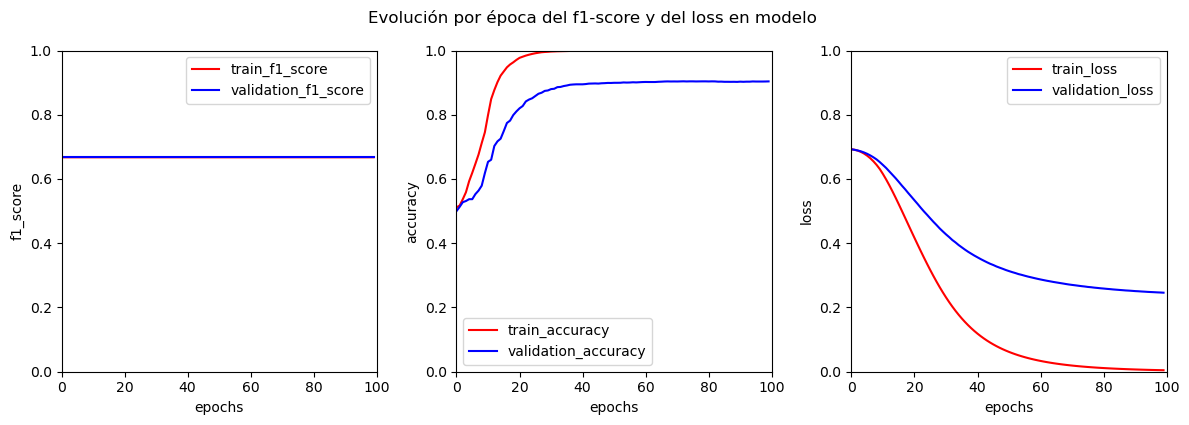

In [54]:
plotComparisonAlongEpochs(perceptronTrainingHistory.history, epochs, "")

En este caso tampoco llegamos a que la red haga overfitting

Realizamos una visualización de las capas de la red neuronal y cómo se conectan con la librería keras-visualizer

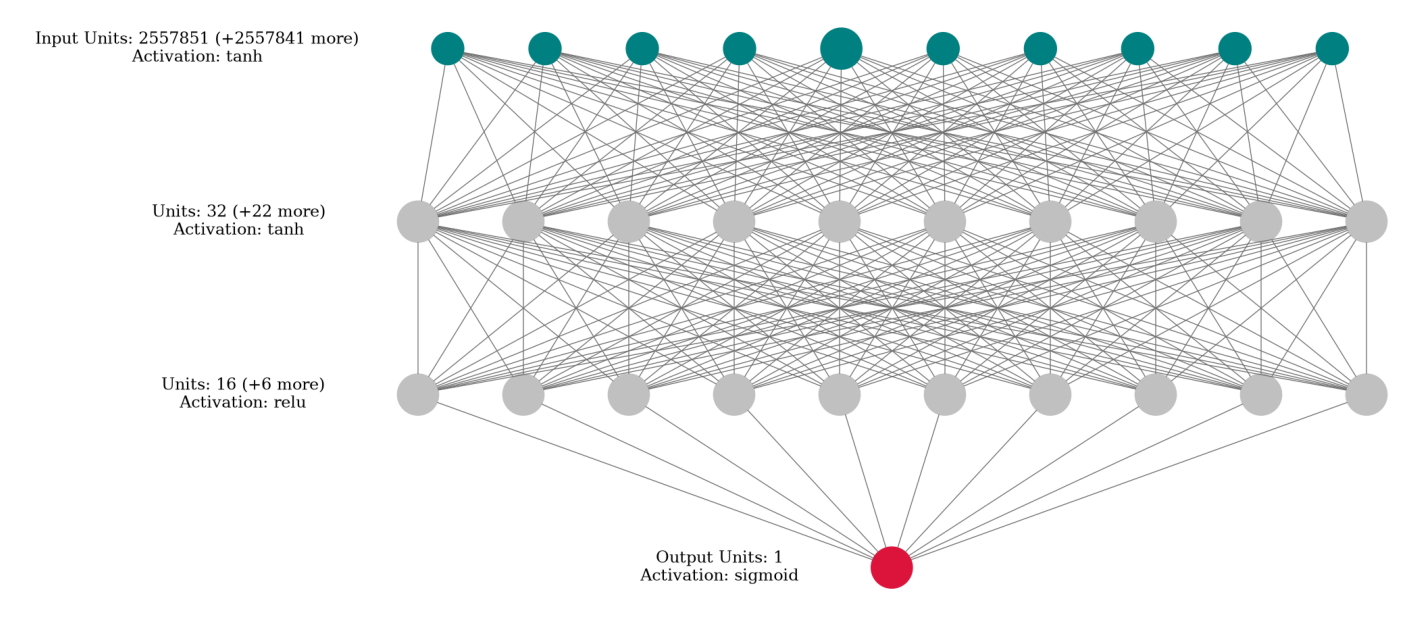

In [11]:
perceptronImagePath = f"./imgs/{runNumber}_perceptron"
my_settings = {
    'INPUT_DENSE_COLOR': 'teal',
    'HIDDEN_DENSE_COLOR': 'gray',
    'OUTPUT_DENSE_COLOR': 'crimson'
}
visualizer(perceptron, view=False, file_name=perceptronImagePath, file_format='png', settings=my_settings)

perceptronImage = plt.imread(f"{perceptronImagePath}.png")

plt.figure(figsize = (18, 16))
plt.axis('off')
plt.imshow(perceptronImage)

Realizamos una visualización de las capas de la red neuronal con la librería visualkeras

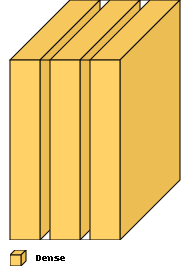

In [12]:
visualkeras.layered_view(perceptron, min_xy=180, min_z=30, legend=True)

Definimos una función para aplicar el procesamiento de datos con una única función antes de mandar a la red, para simplificar la aplicación de las tranformaciones

In [29]:
def processInput(data):
    vectorized = vectorize(data)
    return reorderSparse(vectorized)

Definimos una función para convertir el output de la red, que es una probabilidad, en una decisión binaria (0 para negativo o 1 para positivo)

In [30]:
def convertProbasToClasses(y_pred):
    probaTrigger = 0.5
    return np.where(y_pred > probaTrigger, 1, 0)

Procesamos el conjunto de test y realizamos la predicción

In [32]:
y_pred = perceptron.predict(processInput(x_test))
y_pred = convertProbasToClasses(y_pred)

282/282 [==============================] - 2s 2ms/step


Imprimimos la matriz de confusión. Se agrega una caja de texto con las equivalencias entre las etiquetas numéricas y el sentimiento

F1-Score: 0.899212598425197


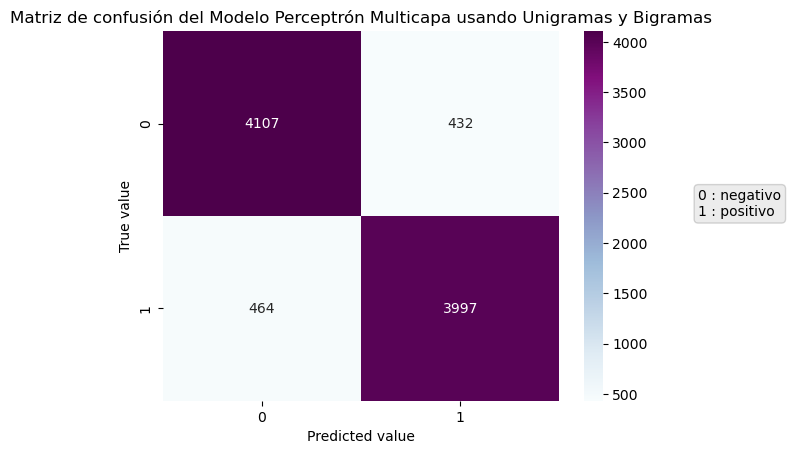

In [33]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

confussionMatrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(confussionMatrix,cmap='BuPu', annot=True, fmt='g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Matriz de confusión del Modelo Perceptrón Multicapa usando Unigramas y Bigramas")
plt.text(2.7, 1, f"0 : {labelEncoder.inverse_transform([0])[0]}\n1 : {labelEncoder.inverse_transform([1])[0]}", bbox=dict(boxstyle='round', facecolor='grey', alpha=0.15))
plt.show()

Mostramos las distintas métricas

In [59]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.9004444444444445
Recall: 0.895987446760816
Precision: 0.902461052156243
f1 score: 0.899212598425197


Realizamos las predicciones de los datos que vamos a submitear a kaggle

In [60]:
y_pred = perceptron.predict(processInput(criticsTest["review"]))
y_pred = convertProbasToClasses(y_pred)

269/269 [==============================] - 0s 1ms/step


Agrupamos en el dataframe los valores predichos decodeados con el label encoder

In [61]:
kaggleResult = criticsTest.copy()
kaggleResult.drop(columns=["review"], inplace=True)

kaggleResult["sentimiento"] = labelEncoder.inverse_transform(y_pred)

kaggleResult.head(2)

,ID,sentimiento
0,60000,negativo
1,60001,negativo


Para exportar a Kaggle exportamos el csv. El `runNumber` es sólo un número que ponemos para no pisar los submits

In [62]:
runNumber = 23

In [63]:
kaggleResult.to_csv(f"submit_{runNumber}_grupo16_gpwin_perceptron_multicapa.csv", index=False)

Guardamos una serialización del modelo

In [64]:
filename = f'./perceptron_multicapa_model_{runNumber}.joblib'
modelInfo = {'model': perceptron}

joblib.dump(modelInfo, filename)

['./perceptron_multicapa_model_23.joblib']

## Modelo Perceptrón Multicapa usando unigramas y bigramas con dropout y regularización L2

Exploraremos el uso de un modelo de red neuronal perceptrón multicapa. El input será de un vectorizer (count vectorizer más tfidf) fijando los n-gramas en unigramas y bigramas

Los parámetros del vectorizer los tomamos teniendo en cuenta el mejor set que obtuvimos cuando hicimos la optimización de hiperparámetros del modelo naive bayes

In [28]:
parametersVectorizer = {
    'strip_accents': 'ascii',
    'lowercase': False,
    'ngram_range': (1,2),
    'binary': True,
    'analyzer': 'word'
}

parametersTransformer = {
    'norm': 'l1',
    'use_idf': True,
    'sublinear_tf': True,
}

vectorizer = CountVectorizer(**parametersVectorizer)
tfidfTransformer = TfidfTransformer(**parametersTransformer)

vectorizer.fit(x_train)
tfidfTransformer.fit(vectorizer.transform(x_train))

TfidfTransformer(norm='l1', sublinear_tf=True)

Creamos una función que aplique los pasos de la tokenización

In [29]:
def vectorize(data):
    vectorized = vectorizer.transform(data)
    return tfidfTransformer.transform(vectorized)

Vectorizamos el conjunto de test y train

In [46]:
x_train_vectorized = vectorizer.transform(x_train)
x_train_vectorized = tfidfTransformer.transform(x_train_vectorized)

x_test_vectorized = vectorizer.transform(x_test)
x_test_vectorized = tfidfTransformer.transform(x_test_vectorized)
print("Tamaño de la matriz train:", x_train_vectorized.shape)
print("Tamaño de la matriz test:", x_test_vectorized.shape)

Tamaño de la matriz train: (41000, 2557851)
Tamaño de la matriz test: (9000, 2557851)


Dado que el tamaño de los vectores será 2557851, seteamos los tamaños de input y output de la red neuronal

In [47]:
inputVariablesAmount = x_train_vectorized.shape[1]
outputVariablesAmount = 1

print(f"Input layer amount: {inputVariablesAmount}")
print(f"Output layer amount: {outputVariablesAmount}")

Input layer amount: 2557851
Output layer amount: 1


El output del vectorizer es una matriz dispersa, pero lo necesitamos en forma de tensor para entrenar la red, este tensor debe seguir un cierto orden (dado que si no aplicamos un reorder, obtenemos un error). Por eso creamos una función que se aplicará a los datos vectorizados, esta descompone la matriz dispersa en coordenadas con las que luego se compone un tensor disperso. Finalmente se ejecuta un reordenamiento del tensor disperso para que sea apto para el training de la red

In [30]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

def reorderSparse(x):
    return tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(x))

Para evaluar la red neuronal registraremos el validation loss, así que definimos una proporción del conjunto de train que se usará para validación, elegimos un ratio de ~1/6.

In [49]:
validationProportion = 0.18

Separamos manualmente las muestras de los conjuntos teniendo en cuenta la proporción de validación, luego le aplicamos la vectorización y el reordenado a los tensores

In [50]:
y_train_float = tf.cast(y_train, tf.float32)

# Separar el conjunto de validación manualmente
validation_samples = int(validationProportion * len(x_train))
x_train_partial = x_train[:-validation_samples]
x_train_partial = vectorize(x_train_partial)
x_train_partial = reorderSparse(x_train_partial)

y_train_partial = y_train_float[:-validation_samples]

x_validation = x_train[-validation_samples:]
x_validation = vectorize(x_validation)
x_validation = reorderSparse(x_validation)

y_validation = y_train_float[-validation_samples:]

2023-12-04 11:56:05.840914: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4097 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


La arquitectura de la red constará de una capa de input, una capa densa de 32 neuronas con regularización L2 y activación tangente hiperbólica con una capa de dropout, seguido de otra capa densa de 16 neuronas con regularización L2 y activación ReLU con una capa de dropout, finalizando con una sóla neurona de output y activación sigmoidea para determinar si la review es negativa o positiva.

Durante el entrenamiento observaremos el f1 score y el accuracy. De función de loss tomamos BinaryCrossentropy dado que es un problema de clasificación binaria, y finalmente usaremos el optimizador Adam.

El modelo se entrenará por un máximo de 200 epochs con batches de a 512. Se aplicará early stopping con una paciencia de 5 epochs

In [ ]:
perceptron = Sequential([
        InputLayer(input_shape=(inputVariablesAmount,)),
        Dense(32, activation="tanh", kernel_regularizer=L2(1e-6)),
        Dropout(0.1, seed=0),
        Dense(16, activation='relu', kernel_regularizer=L2(1e-6)),
        Dropout(0.1, seed=0),
        Dense(outputVariablesAmount, activation='sigmoid')
])

f1Scorer =  tf.keras.metrics.F1Score()
binaryCrossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

learningRate = 0.00005
nadamOptimizer = tf.keras.optimizers.Adam(learning_rate=learningRate)

perceptron.compile(loss=binaryCrossentropy,
                        optimizer=nadamOptimizer,
                        metrics=[f1Scorer, "accuracy"])

epochs = 200
batchSize = 512

earlyStopping = tf.keras.callbacks.EarlyStopping(
                            patience=5,
                            min_delta=0.00001,                               
                            monitor="val_loss",
                            restore_best_weights=False
                            )

Ejecutamos el entrenamiento de la red

In [ ]:
perceptronTrainingHistory = perceptron.fit(x_train_partial,
                                        y_train_partial,
                                        epochs=epochs,
                                        batch_size=batchSize,
                                        validation_data=(x_validation, y_validation),
                                        callbacks=[earlyStopping],
                                        use_multiprocessing= True,
                                        verbose=0)

Entrenamos por unas nuevas máximas 100 epochs

In [ ]:
perceptronTrainingHistory2 = perceptron.fit(x_train_partial,
                                            y_train_partial,
                                            epochs=100,
                                            batch_size=batchSize,
                                            validation_data=(x_validation, y_validation),
                                            callbacks=[earlyStopping],
                                            use_multiprocessing= True,
                                            verbose=0)

En total la red se entrenó por 233 epochs, deteniéndose el mismo por el early stopping

Definimos una función para graficar el progreso del f1 score, el accuracy y el loss a través de las epochs

In [59]:
def plotComparisonAlongEpochs(history, epochsParam, infoModel):
    epochsRange = range(epochsParam)
    figure, subplots = plt.subplots(1, 3, figsize=(12, 4))
    plt.ylim(0, 0.8)

    subplots[0].plot(epochsRange, history['f1_score'], color='red', label='f1_score')
    subplots[0].plot(epochsRange, history['val_f1_score'], color='blue', label='f1_score')
    subplots[0].set_xlabel("epochs")
    subplots[0].set_ylabel("f1_score")
    subplots[0].set_ylim(0, 1.0)
    subplots[0].set_xlim(0, epochsParam)
    subplots[0].legend(["train_f1_score", "validation_f1_score"])

    subplots[1].plot(epochsRange, history['accuracy'], color='red', label='loss')
    subplots[1].plot(epochsRange, history['val_accuracy'], color='blue', label='loss')
    subplots[1].set_xlabel("epochs")
    subplots[1].set_ylabel("accuracy")
    subplots[1].set_ylim(0, 1.0)
    subplots[1].set_xlim(0, epochsParam)
    subplots[1].legend(["train_accuracy", "validation_accuracy"])

    subplots[2].plot(epochsRange, history['loss'], color='red', label='loss')
    subplots[2].plot(epochsRange, history['val_loss'], color='blue', label='loss')
    subplots[2].set_xlabel("epochs")
    subplots[2].set_ylabel("loss")
    subplots[2].legend(["train_loss", "validation_loss"])

    maxLoss = max(history['loss'])
    if maxLoss > 1:
        subplots[2].set_ylim(0, maxLoss)
    else:
        subplots[2].set_ylim(0, 1.0)

    subplots[2].set_xlim(0, epochsParam)

    plt.tight_layout()
    figure.suptitle(f"Evolución por época del f1-score y del loss en modelo {infoModel}", y=1.05)
    plt.show()

Mostramos el gráfico comparativo de las primeras 200 epochs

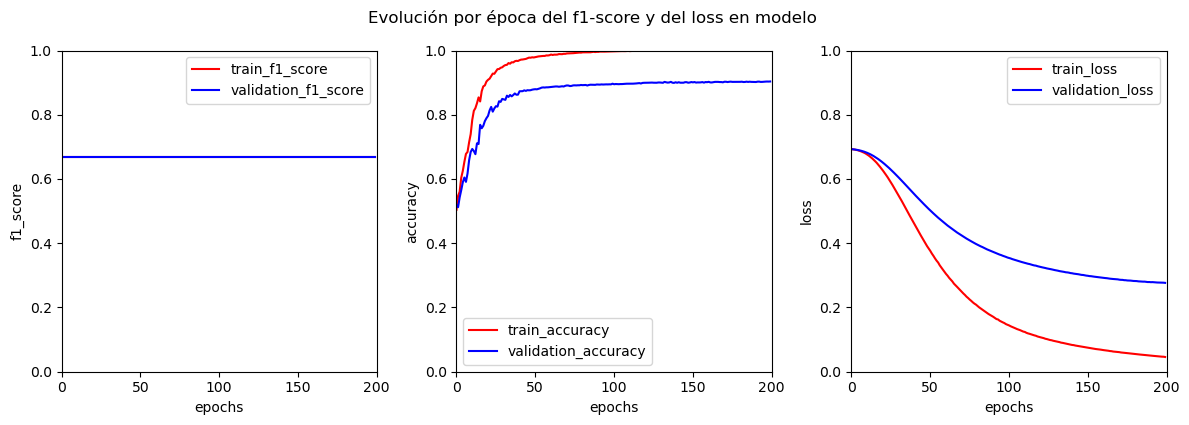

In [60]:
plotComparisonAlongEpochs(perceptronTrainingHistory.history, 200, "")

El entrenamiento tuvo una buena evolución

Mostramos el gráfico comparativo de las últimas 33 epochs

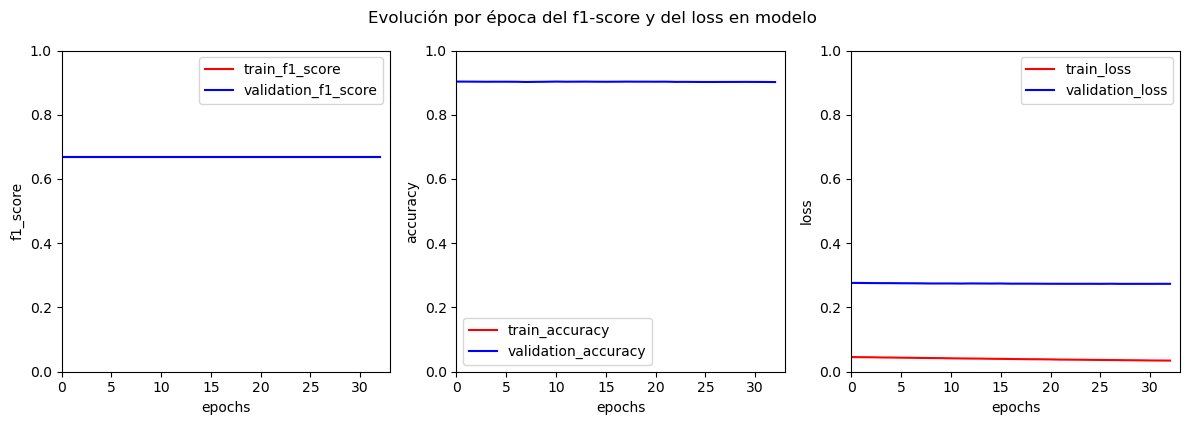

In [61]:
plotComparisonAlongEpochs(perceptronTrainingHistory2.history, 33, "")

En estas últimas epochs la red casi no tuvo cambios y comenzó a hacer overfitting dado que paró por el early stopping

Realizamos una visualización de las capas de la red neuronal y cómo se conectan con la librería keras-visualizer

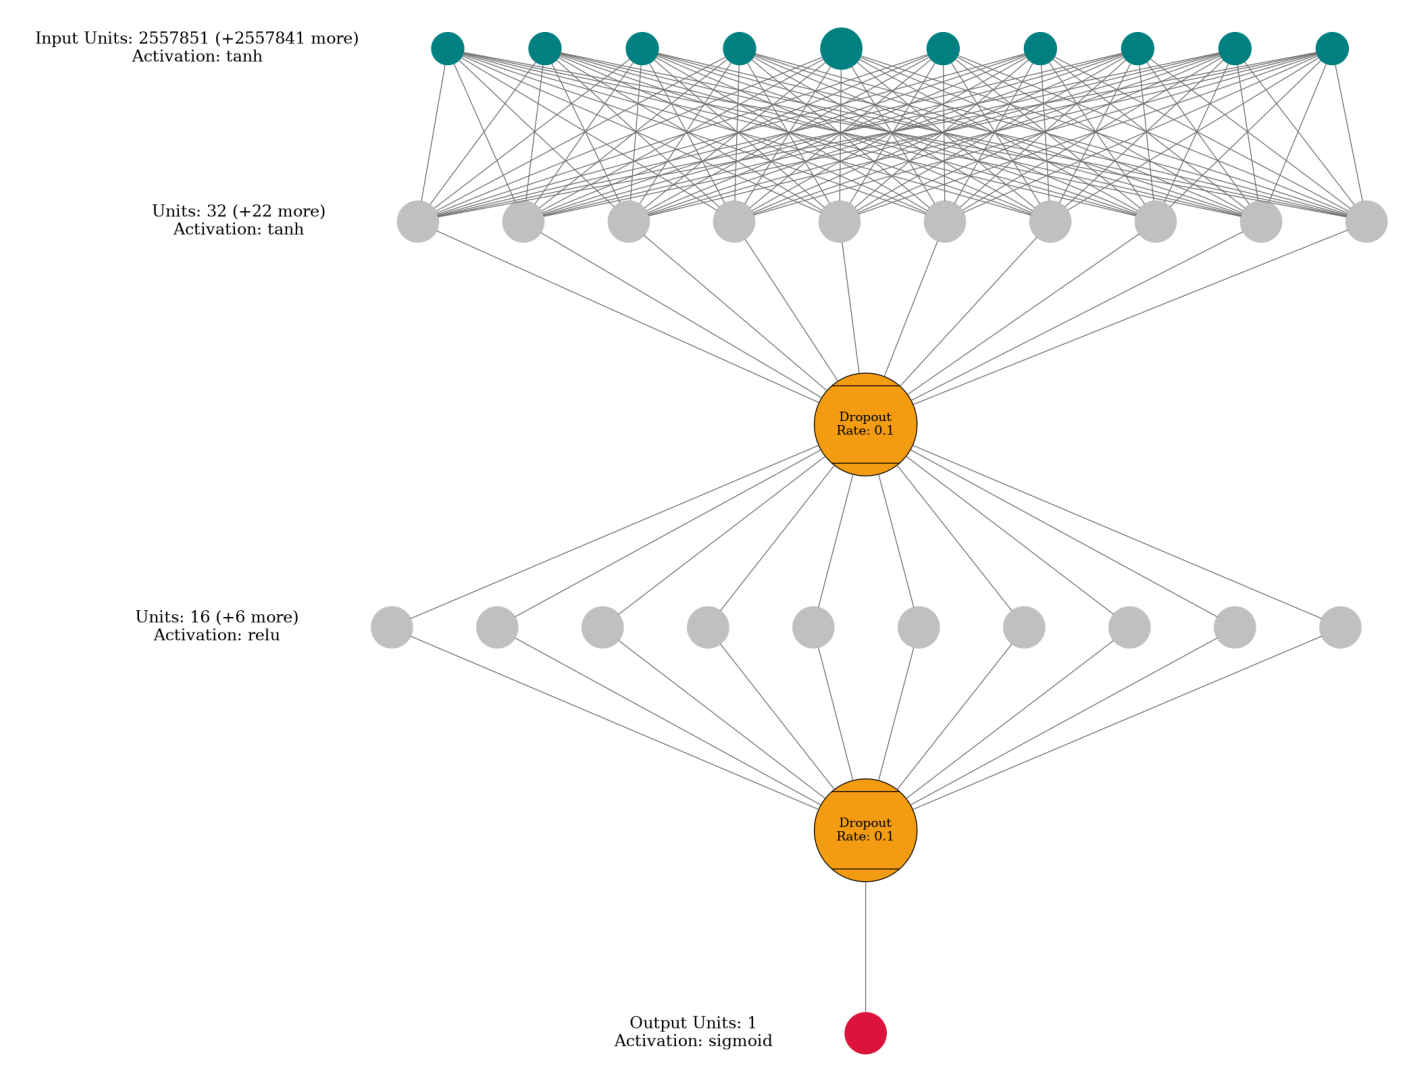

In [14]:
perceptronImagePath = f"./imgs/{runNumber}_perceptron"
my_settings = {
    'INPUT_DENSE_COLOR': 'teal',
    'HIDDEN_DENSE_COLOR': 'gray',
    'OUTPUT_DENSE_COLOR': 'crimson'
}
visualizer(perceptron, view=False, file_name=perceptronImagePath, file_format='png', settings=my_settings)

perceptronImage = plt.imread(f"{perceptronImagePath}.png")

plt.figure(figsize = (18, 16))
plt.axis('off')
plt.imshow(perceptronImage)

Realizamos una visualización de las capas de la red neuronal con la librería visualkeras

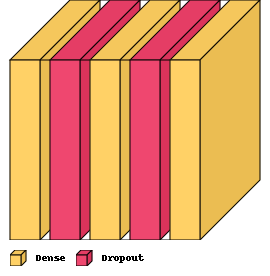

In [15]:
visualkeras.layered_view(perceptron, min_xy=180, min_z=30, legend=True)

Definimos una función para aplicar el procesamiento de datos con una única función antes de mandar a la red, para simplificar la aplicación de las tranformaciones

In [31]:
def processInput(data):
    vectorized = vectorize(data)
    return reorderSparse(vectorized)

Definimos una función para convertir el output de la red, que es una probabilidad, en una decisión binaria (0 para negativo o 1 para positivo)

In [32]:
def convertProbasToClasses(y_pred):
    probaTrigger = 0.5
    return np.where(y_pred > probaTrigger, 1, 0)

Procesamos el conjunto de test y realizamos la predicción

In [33]:
y_pred = perceptron.predict(processInput(x_test))
y_pred = convertProbasToClasses(y_pred)

282/282 [==============================] - 2s 2ms/step


Imprimimos la matriz de confusión. Se agrega una caja de texto con las equivalencias entre las etiquetas numéricas y el sentimiento

F1-Score: 0.8958955636685473


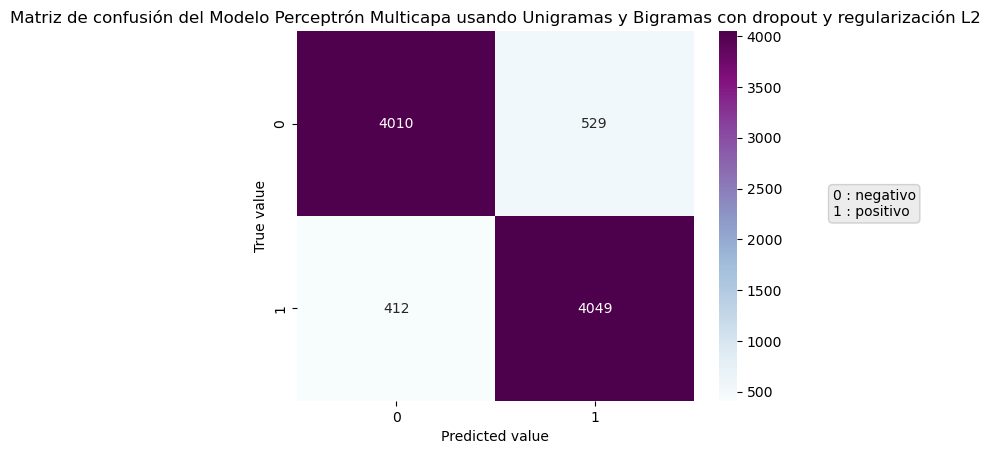

In [34]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

confussionMatrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(confussionMatrix,cmap='BuPu', annot=True, fmt='g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Matriz de confusión del Modelo Perceptrón Multicapa usando Unigramas y Bigramas con dropout y regularización L2")
plt.text(2.7, 1, f"0 : {labelEncoder.inverse_transform([0])[0]}\n1 : {labelEncoder.inverse_transform([1])[0]}", bbox=dict(boxstyle='round', facecolor='grey', alpha=0.15))
plt.show()

Mostramos las distintas métricas

In [66]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.8954444444444445
Recall: 0.9076440260031383
Precision: 0.8844473569244211
f1 score: 0.8958955636685473


Realizamos las predicciones de los datos que vamos a submitear a kaggle

In [67]:
y_pred = perceptron.predict(processInput(criticsTest["review"]))
y_pred = convertProbasToClasses(y_pred)

269/269 [==============================] - 0s 1ms/step


Agrupamos en el dataframe los valores predichos decodeados con el label encoder

In [68]:
kaggleResult = criticsTest.copy()
kaggleResult.drop(columns=["review"], inplace=True)

kaggleResult["sentimiento"] = labelEncoder.inverse_transform(y_pred)

kaggleResult.head(2)

,ID,sentimiento
0,60000,negativo
1,60001,negativo


Para exportar a Kaggle exportamos el csv. El `runNumber` es sólo un número que ponemos para no pisar los submits

In [69]:
runNumber = 24

In [70]:
kaggleResult.to_csv(f"submit_{runNumber}_grupo16_gpwin_perceptron_multicapa.csv", index=False)

Guardamos una serialización del modelo

In [71]:
filename = f'./perceptron_multicapa_model_{runNumber}.joblib'
modelInfo = {'model': perceptron}

joblib.dump(modelInfo, filename)

['./perceptron_multicapa_model_24.joblib']

## Modelo Deep Learning


Exploraremos el uso de un modelo red neuronal deep learning. El input será de un vectorizer (count vectorizer más tfidf) fijando los n-gramas en unigramas y bigramas

Los parámetros del vectorizer los tomamos teniendo en cuenta el mejor set que obtuvimos cuando hicimos la optimización de hiperparámetros del modelo naive bayes

In [26]:
parametersVectorizer = {
    'strip_accents': 'ascii',
    'lowercase': False,
    'ngram_range': (1,2),
    'binary': True,
    'analyzer': 'word'
}

parametersTransformer = {
    'norm': 'l1',
    'use_idf': True,
    'sublinear_tf': True,
}

vectorizer = CountVectorizer(**parametersVectorizer)
tfidfTransformer = TfidfTransformer(**parametersTransformer)

vectorizer.fit(x_train)
tfidfTransformer.fit(vectorizer.transform(x_train))

TfidfTransformer(norm='l1', sublinear_tf=True)

Creamos una función que aplique los pasos de la tokenización

In [27]:
def vectorize(data):
    vectorized = vectorizer.transform(data)
    return tfidfTransformer.transform(vectorized)

Vectorizamos el conjunto de test y train

In [46]:
x_train_vectorized = vectorizer.transform(x_train)
x_train_vectorized = tfidfTransformer.transform(x_train_vectorized)

x_test_vectorized = vectorizer.transform(x_test)
x_test_vectorized = tfidfTransformer.transform(x_test_vectorized)
print("Tamaño de la matriz train:", x_train_vectorized.shape)
print("Tamaño de la matriz test:", x_test_vectorized.shape)

Tamaño de la matriz train: (41000, 2557851)
Tamaño de la matriz test: (9000, 2557851)


Dado que el tamaño de los vectores será 2557851, seteamos los tamaños de input y output de la red neuronal

In [47]:
inputVariablesAmount = x_train_vectorized.shape[1]
outputVariablesAmount = 1

print(f"Input layer amount: {inputVariablesAmount}")
print(f"Output layer amount: {outputVariablesAmount}")

Input layer amount: 2557851
Output layer amount: 1


El output del vectorizer es una matriz dispersa, pero lo necesitamos en forma de tensor para entrenar la red, este tensor debe seguir un cierto orden (dado que si no aplicamos un reorder, obtenemos un error). Por eso creamos una función que se aplicará a los datos vectorizados, esta descompone la matriz dispersa en coordenadas con las que luego se compone un tensor disperso. Finalmente se ejecuta un reordenamiento del tensor disperso para que sea apto para el training de la red

In [28]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

def reorderSparse(x):
    return tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(x))

Para evaluar la red neuronal registraremos el validation loss, así que definimos una proporción del conjunto de train que se usará para validación, elegimos un ratio de ~1/6.

In [49]:
validationProportion = 0.18

Separamos manualmente las muestras de los conjuntos teniendo en cuenta la proporción de validación, luego le aplicamos la vectorización y el reordenado a los tensores

In [50]:
y_train_float = tf.cast(y_train, tf.float32)

# Separar el conjunto de validación manualmente
validation_samples = int(validationProportion * len(x_train))
x_train_partial = x_train[:-validation_samples]
x_train_partial = vectorize(x_train_partial)
x_train_partial = reorderSparse(x_train_partial)

y_train_partial = y_train_float[:-validation_samples]

x_validation = x_train[-validation_samples:]
x_validation = vectorize(x_validation)
x_validation = reorderSparse(x_validation)

y_validation = y_train_float[-validation_samples:]

2023-12-04 13:14:12.416985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4097 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


La arquitectura de la red constará de una capa de input, una capa densa de 32 neuronas con regularización L2 y activación tangente hiperbólica con una capa de dropout, seguido de otra capa densa de 2048 neuronas con regularización L2 y activación tangente hiperbólica con una capa de dropout, seguido de otra capa densa de 1024 neuronas con regularización L2 y activación ReLU con una capa de dropout, seguido de otra capa densa de 16 neuronas con regularización L2 y activación ReLU, finalizando con una sóla neurona de output y activación sigmoidea para determinar si la review es negativa o positiva.

Durante el entrenamiento observaremos el f1 score y el accuracy. De función de loss tomamos BinaryCrossentropy dado que es un problema de clasificación binaria, y finalmente usaremos el optimizador Nadam.

In [55]:
deepLearningModel = Sequential([
        InputLayer(input_shape=(inputVariablesAmount,)),
        Dense(32, activation="tanh", kernel_regularizer=L2(1e-6)),
        Dropout(0.1, seed=0),
        Dense(2048, activation='tanh', kernel_regularizer=L2(1e-6)),
        Dropout(0.1, seed=0),
        Dense(1024, activation='relu', kernel_regularizer=L2(1e-6)),
        Dropout(0.1, seed=0),
        Dense(16, activation='relu', kernel_regularizer=L2(1e-6)),
        Dense(outputVariablesAmount, activation='sigmoid')
])

f1Scorer =  tf.keras.metrics.F1Score()
binaryCrossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

learningRate = 0.000005
nadamOptimizer = tf.keras.optimizers.Nadam(learning_rate=learningRate)

deepLearningModel.compile(loss=binaryCrossentropy,
                        optimizer=nadamOptimizer,
                        metrics=[f1Scorer, "accuracy"])


deepLearningModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                81851264  
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 2048)              67584     
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 16)               

El modelo se entrenará por un máximo de 200 epochs con batches de a 512. Se aplicará early stopping con una paciencia de 5 epochs

In [ ]:
epochs = 200
batchSize = 512

earlyStopping = tf.keras.callbacks.EarlyStopping(
                            patience=5,
                            min_delta=0.00001,                               
                            monitor="val_loss",
                            restore_best_weights=False
                            )

Ejecutamos el entrenamiento de la red

In [ ]:
deepLearningModelTrainingHistory = deepLearningModel.fit(x_train_partial,
                                                y_train_partial,
                                                epochs=epochs,
                                                batch_size=batchSize,
                                                validation_data=(x_validation, y_validation),
                                                callbacks=[earlyStopping],
                                                use_multiprocessing= True,
                                                verbose=0)

En total la red se entrenó por 118 epochs, deteniéndose el mismo por el early stopping

Definimos una función para graficar el progreso del f1 score, el accuracy y el loss a través de las epochs

In [57]:
def plotComparisonAlongEpochs(history, epochsParam, infoModel):
    epochsRange = range(epochsParam)
    figure, subplots = plt.subplots(1, 3, figsize=(12, 4))
    plt.ylim(0, 0.8)

    subplots[0].plot(epochsRange, history['f1_score'], color='red', label='f1_score')
    subplots[0].plot(epochsRange, history['val_f1_score'], color='blue', label='f1_score')
    subplots[0].set_xlabel("epochs")
    subplots[0].set_ylabel("f1_score")
    subplots[0].set_ylim(0, 1.0)
    subplots[0].set_xlim(0, epochsParam)
    subplots[0].legend(["train_f1_score", "validation_f1_score"])

    subplots[1].plot(epochsRange, history['accuracy'], color='red', label='loss')
    subplots[1].plot(epochsRange, history['val_accuracy'], color='blue', label='loss')
    subplots[1].set_xlabel("epochs")
    subplots[1].set_ylabel("accuracy")
    subplots[1].set_ylim(0, 1.0)
    subplots[1].set_xlim(0, epochsParam)
    subplots[1].legend(["train_accuracy", "validation_accuracy"])

    subplots[2].plot(epochsRange, history['loss'], color='red', label='loss')
    subplots[2].plot(epochsRange, history['val_loss'], color='blue', label='loss')
    subplots[2].set_xlabel("epochs")
    subplots[2].set_ylabel("loss")
    subplots[2].legend(["train_loss", "validation_loss"])

    maxLoss = max(history['loss'])
    if maxLoss > 1:
        subplots[2].set_ylim(0, maxLoss)
    else:
        subplots[2].set_ylim(0, 1.0)

    subplots[2].set_xlim(0, epochsParam)

    plt.tight_layout()
    figure.suptitle(f"Evolución por época del f1-score y del loss en modelo {infoModel}", y=1.05)
    plt.show()

Mostramos el gráfico comparativo

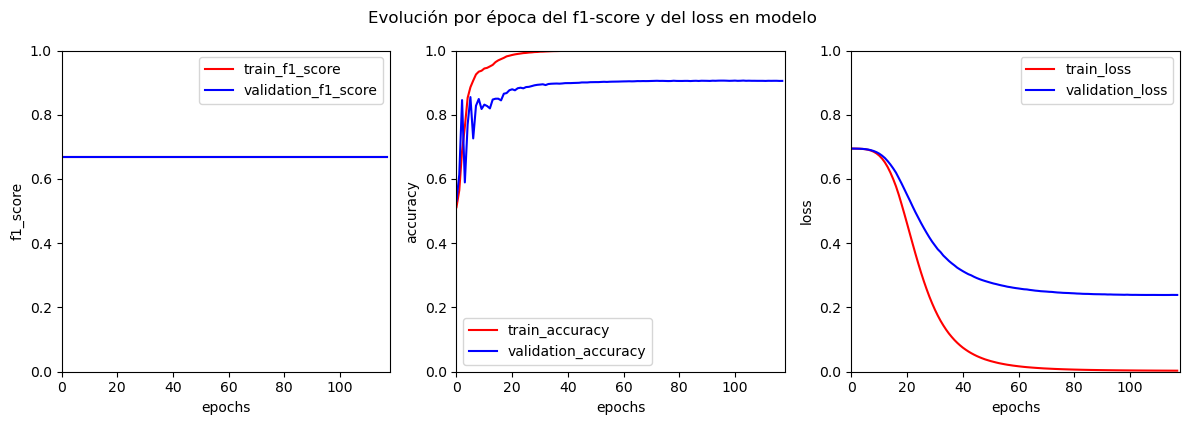

In [59]:
plotComparisonAlongEpochs(deepLearningModelTrainingHistory.history, 118, "")

El entrenamiento tuvo una buena evolución y se detuvo porque el validation loss no continuó descendiendo

Realizamos una visualización de las capas de la red neuronal y cómo se conectan con la librería keras-visualizer

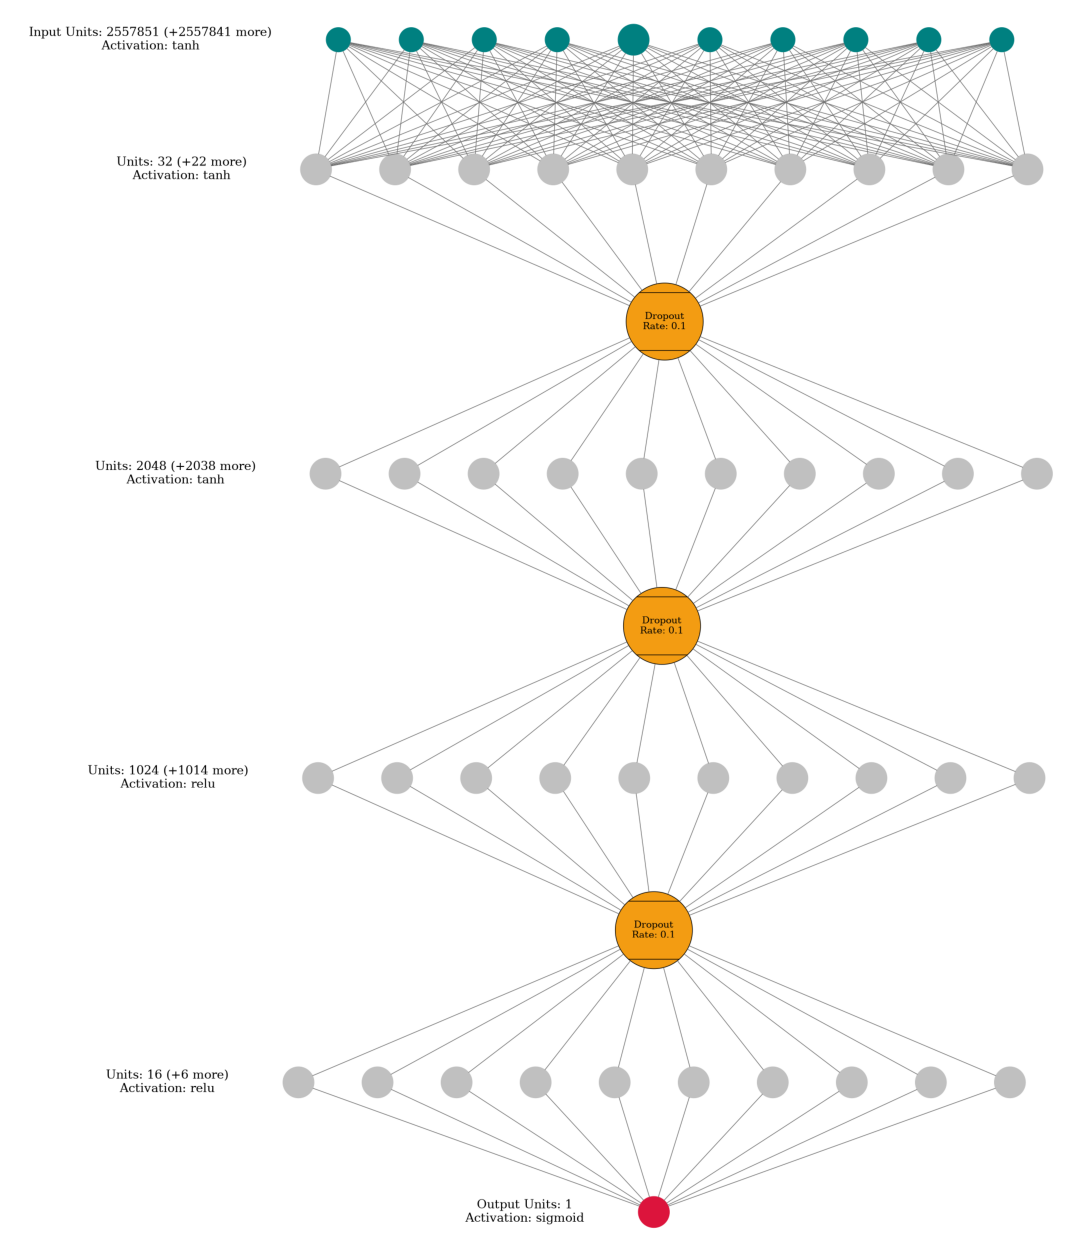

In [17]:
deepLearningModelImagePath = f"./imgs/{runNumber}_deep_learning_model"
my_settings = {
    'INPUT_DENSE_COLOR': 'teal',
    'HIDDEN_DENSE_COLOR': 'gray',
    'OUTPUT_DENSE_COLOR': 'crimson'
}
visualizer(deepLearningModel, view=False, file_name=deepLearningModelImagePath, file_format='png', settings=my_settings)

deepLearningModelImage = plt.imread(f"{deepLearningModelImagePath}.png")

plt.figure(figsize = (18, 16))
plt.axis('off')
plt.imshow(deepLearningModelImage)

Realizamos una visualización de las capas de la red neuronal con la librería visualkeras

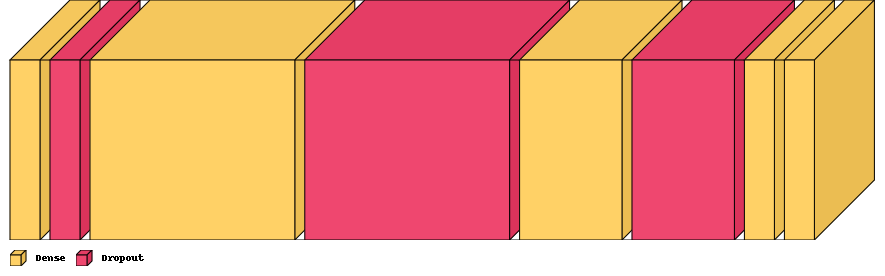

In [18]:
visualkeras.layered_view(deepLearningModel, min_xy=180, min_z=30, legend=True)

Definimos una función para aplicar el procesamiento de datos con una única función antes de mandar a la red, para simplificar la aplicación de las tranformaciones

In [29]:
def processInput(data):
    vectorized = vectorize(data)
    return reorderSparse(vectorized)

Definimos una función para convertir el output de la red, que es una probabilidad, en una decisión binaria (0 para negativo o 1 para positivo)

In [30]:
def convertProbasToClasses(y_pred):
    probaTrigger = 0.5
    return np.where(y_pred > probaTrigger, 1, 0)

Procesamos el conjunto de test y realizamos la predicción

In [32]:
y_pred = deepLearningModel.predict(processInput(x_test))
y_pred = convertProbasToClasses(y_pred)

282/282 [==============================] - 2s 2ms/step


Imprimimos la matriz de confusión. Se agrega una caja de texto con las equivalencias entre las etiquetas numéricas y el sentimiento

F1-Score: 0.903369287223396


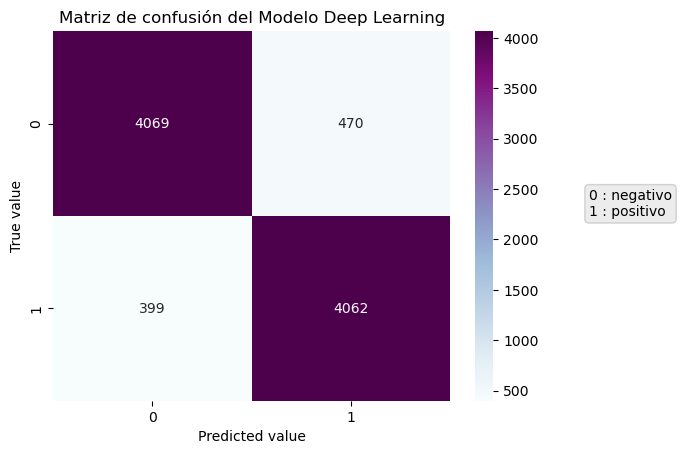

In [33]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

confussionMatrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(confussionMatrix,cmap='BuPu', annot=True, fmt='g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Matriz de confusión del Modelo Deep Learning")
plt.text(2.7, 1, f"0 : {labelEncoder.inverse_transform([0])[0]}\n1 : {labelEncoder.inverse_transform([1])[0]}", bbox=dict(boxstyle='round', facecolor='grey', alpha=0.15))
plt.show()

Mostramos las distintas métricas

In [64]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.9034444444444445
Recall: 0.9105581708137189
Precision: 0.8962930273609885
f1 score: 0.903369287223396


Realizamos las predicciones de los datos que vamos a submitear a kaggle

In [65]:
y_pred = deepLearningModel.predict(processInput(criticsTest["review"]))
y_pred = convertProbasToClasses(y_pred)

269/269 [==============================] - 0s 2ms/step


Agrupamos en el dataframe los valores predichos decodeados con el label encoder

In [66]:
kaggleResult = criticsTest.copy()
kaggleResult.drop(columns=["review"], inplace=True)

kaggleResult["sentimiento"] = labelEncoder.inverse_transform(y_pred)

kaggleResult.head(2)

,ID,sentimiento
0,60000,negativo
1,60001,negativo


Para exportar a Kaggle exportamos el csv. El `runNumber` es sólo un número que ponemos para no pisar los submits

In [67]:
runNumber = 26

In [68]:
kaggleResult.to_csv(f"submit_{runNumber}_grupo16_gpwin_deep_learning_model.csv", index=False)

Guardamos una serialización del modelo

In [19]:
filename = f'./deep_learning_model_{runNumber}.joblib'
modelInfo = {'model': deepLearningModel}

joblib.dump(modelInfo, filename)

['./deep_learning_model_26.joblib']
